In [133]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
import random
import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import NuSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# Machine Learning Final Project
- Lior Breitman 212733257
- Netanel Levine 312512619
- In this project, We are trying to classify picutres of different landscaped using method we learned in the machine learning course, and also some methods from deep learning courses.
- We are going to use:
    - Logistic regression
    - KNN
    - SVM (linear and polynomial)
    - AdaBoost
    - CNN
    - MLP
- The data is distributed to 3 sets: Training, validation and test, and 5 classes: Coast, Glacier, Forest, Mountain, Dessert
    - Training has 10000 pictures
    - Validation has 1500 pictures
    - Test has 500 pictures
    - The data is distributed evenly between the classes
- To add some more training data, here are some methods that we can use:
    - Flipping the image and adding it
    - Adding Noise to the image (Salt and Pepper, Blur)
    - Rotating the image a bit 
- Questions we want to answer with in this notebook are:
    - With what accuracy can we classify the images?
    - How does adding noise affect the accuracy?
    - Will the “primative” models be able to produce similar result to the deep learning models?
    - Can we the classify the images also as black and white (and not RGB)?
* Some of the methods and Questions have not been answerd or used, we are planning to continute working on it

In [2]:
Path = "D:\\study\\Landscape_Classification"

### Pre Processing
The functions below act as our "pre-processing" even though the data is pretty ready to run.

The only thing we needed to do was reshape the images to sizes we want, blur them, and change the labels from string to numbers

In [156]:
def blurImages2D(images):
    blurred = []
    for i in range(len(images)):
        blur = cv2.GaussianBlur(images[i],(5,5),0)
        blurred.append(blur)
    return blurred

In [163]:
def blurImages(images):
    blurred = np.zeros_like(images)
    for i in range(len(images)):
        B = images[i][:75*75]
        G = images[i][75*75:2*75*75]
        R = images[i][2*(75*75):]
        b = cv2.resize(B,(75,75))
        g = cv2.resize(G,(75,75))
        r = cv2.resize(R,(75,75))
        rgb = np.dstack((r,g,b))
        blur = cv2.GaussianBlur(rgb,(5,5),0)
        blurred[i] = blur.flatten()
    return blurred

In [36]:
def numToLabel(label):
    if label == 1:
        return 'Coast'
    if label == 2:
        return 'Desert'
    if label == 3:
        return 'Forest'
    if label == 4:
        return 'Glacier'
    if label == 5:
        return 'Mountain'

In [4]:
def labelToNum(label):
    if label == 'Coast':
        return 1
    if label ==  'Desert':
        return 2
    if label == 'Forest':
        return 3
    if label == 'Glacier':
        return 4
    if label == 'Mountain':
        return 5

In [41]:
def LoadImages2D(Path):
    data = []
    labels = []
    first = True
    paths = os.listdir(Path)
    for Dir in paths:
        dir_time = time.time()
        for file in os.listdir(f"{Path}\\{Dir}"):
            image = cv2.imread(f"{Path}\\{Dir}\\{file}")#RGB
            image = cv2.resize(image,(75,75))#smaller resolution, dont want too big images
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data.append(image)
            labels.append(labelToNum(Dir))
    return data,labels

In [5]:
def LoadImages(Path):
    Training = False
    if 'Training' in Path:
        data = np.ndarray((2*10000,75*75*3))
        Training = True
    elif 'Validation' in Path:
        data = np.ndarray((1500,75*75*3))
    else:
        data = np.ndarray((500,75*75*3))
    labels = []
    first = True
    paths = os.listdir(Path)
    i = 0
    for Dir in paths:
        dir_time = time.time()
        for file in os.listdir(f"{Path}\\{Dir}"):
            image = cv2.imread(f"{Path}\\{Dir}\\{file}")#BGR
            image = cv2.resize(image,(75,75))#smaller resolution, dont want too big images
            pixels = image.flatten()
            data[i] = pixels
            i +=1
            labels.append(labelToNum(Dir))
            if Training:
                image = cv2.flip(image,1)#Adding flipped horizontaly image to make more training examples
                pixels = image.flatten()
                data[i] = pixels
                i +=1
                labels.append(labelToNum(Dir))
    return data,labels

In [42]:
def LoadData2D():
    train_data, train_labels = LoadImages2D(f"{Path}\\Training")
    valid_data, valid_labels = LoadImages2D(f"{Path}\\Validation")
    test_data, test_labels = LoadImages2D(f"{Path}\\Testing")
    return train_data,train_labels,valid_data,valid_labels,test_data,test_labels

In [6]:
def LoadData():
    train_data, train_labels = LoadImages(f"{Path}\\Training")
    valid_data, valid_labels = LoadImages(f"{Path}\\Validation")
    test_data, test_labels = LoadImages(f"{Path}\\Testing")
    return train_data,train_labels,valid_data,valid_labels,test_data,test_labels

In [103]:
train_data,train_labels,valid_data,valid_labels,test_data,test_labels = LoadData()
train_data2D,train_labels2D,valid_data2D,valid_labels2D,test_data2D,test_labels2D = LoadData2D()

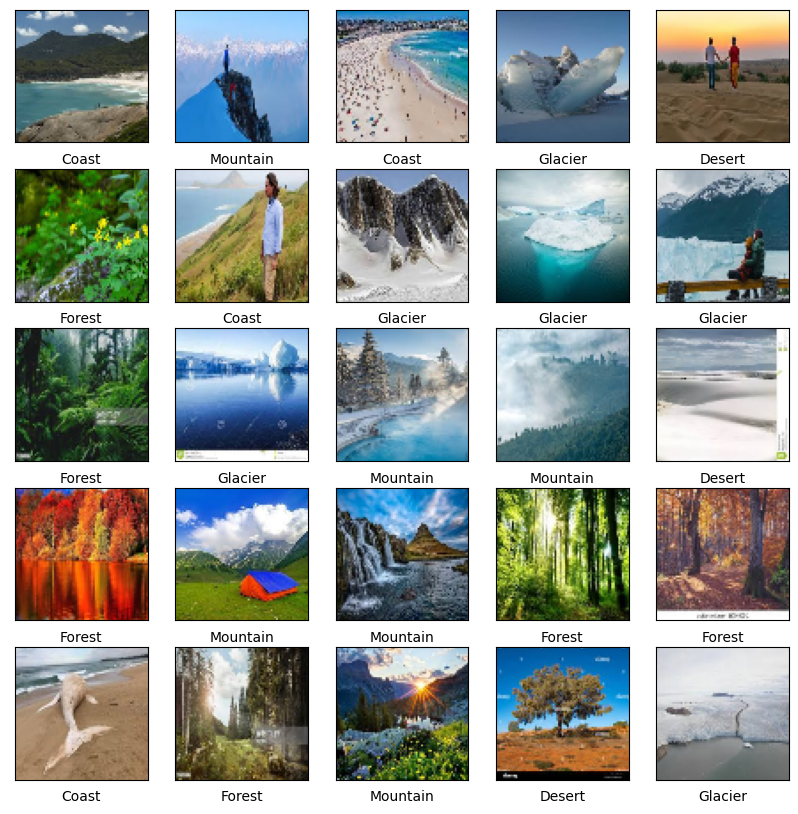

In [117]:
plt.figure(figsize=(10,10))
for i in range(25):
    index = np.random.randint(len(train_data2D)-1)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data2D[index])
    plt.xlabel(numToLabel(train_labels2D[index]))
plt.show()

In [184]:
methods = ['linear svm','polynomial svm','adaboost','logistic regression','MLP','knn','CNN']
final_scores_train = [0.96935,0.6906,0.57215,0.6829,0.7212,0.5895,0.9333]
final_scores_valid = [0.4513333333333333,0.5966666666666667,0.508,0.5586666666666666,0.6020,0.544,0.6453]
seconds_to_train = [3778,5431,2000,60,1932,0.4,840]

First, lets try the basic model of them all, logistic regression

In [32]:
logic = LogisticRegression(random_state = 5)
start = time.time()
logic.fit(train_data, train_labels)
print(f'it took {time.time() - start} to fit logistic regression')

it took 59.14430522918701 to fit logistic regression


In [33]:
print(logic.score(train_data, train_labels))
print(logic.score(valid_data, valid_labels))

0.6829
0.5586666666666666


After using logistic regression, I will try to find the best number of neighbours for KNN

In [68]:
n_range = np.arange(50,1001,50)
valid_scores = []
train_scores = []
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(train_data,train_labels)
    valid_scores.append(knn.score(valid_data,valid_labels))
    train_scores.append(knn.score(train_data,train_labels))

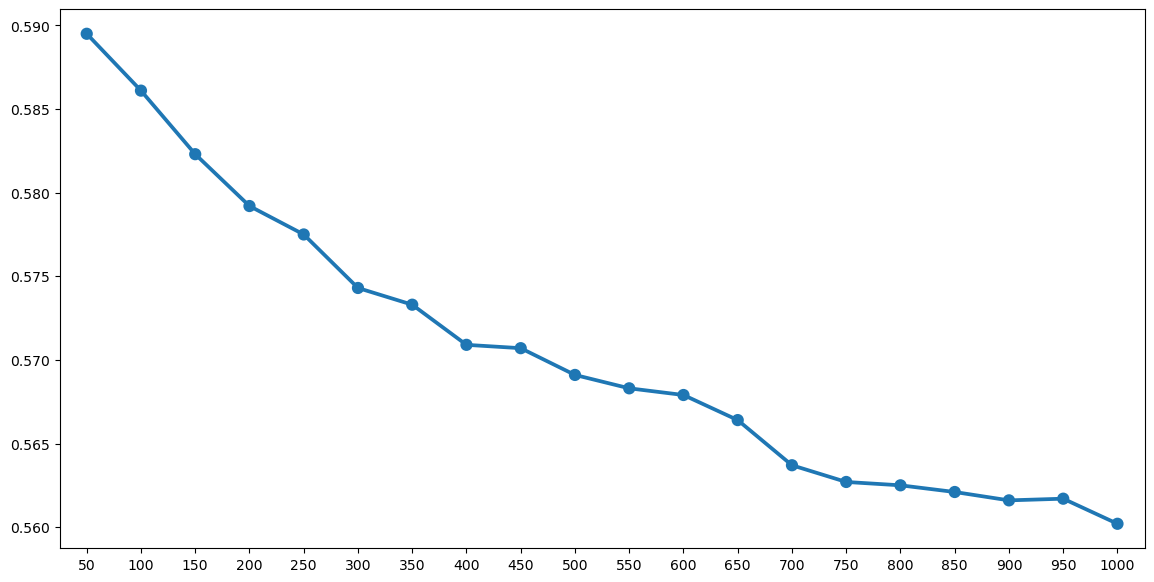

In [69]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = train_scores);

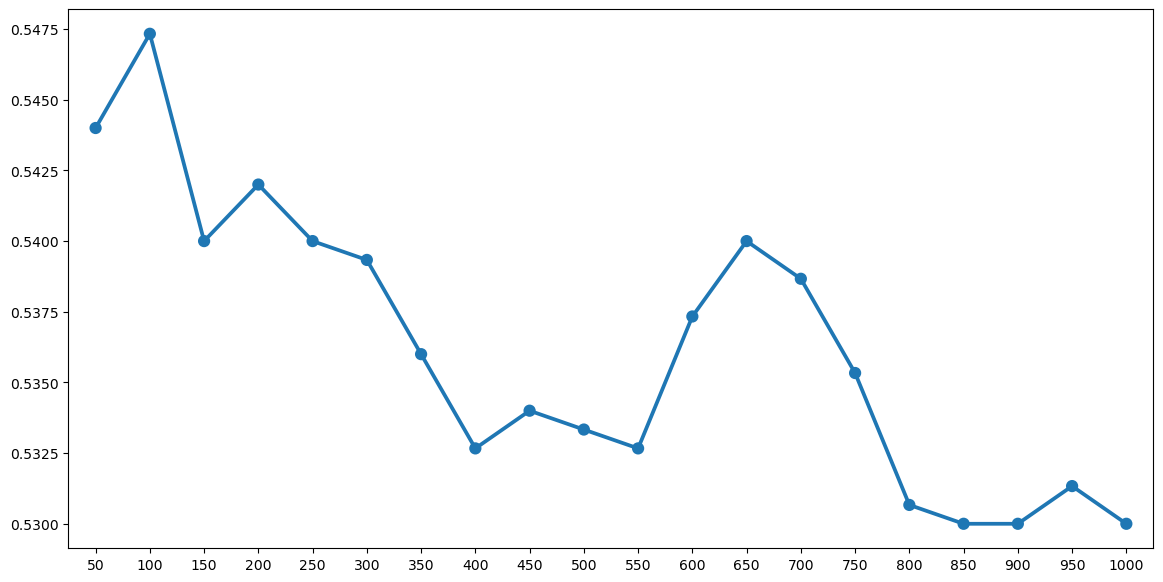

In [70]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = valid_scores);

In [31]:
knn = KNeighborsClassifier(n_neighbors = 50)
start = time.time()
knn.fit(train_data,train_labels)
print(f'took {time.time() - start} to train knn with 50 neighbours')
print(knn.score(valid_data,valid_labels))
print(knn.score(train_data,train_labels))

took 0.41414666175842285 to train knn with 50 neighbours
0.544
0.5895


We can see that we don't need a lot of neighbours, and the best scores were with 50 neighbours, This may be becuase we get a lot of neighbours that are far and we don't want them.

Now let's try SVM with linear kernel

In [10]:
start = time.time()
base_svm = LinearSVC()
base_svm.fit(train_data,train_labels)
print(f"It took {time.time()-start} to train linear SVM")

It took 3778.6239759922028 to train linear SVM


After trying SVM with linear kernel, let's try with polynomial kernel. By default in sklearn the degree of the polynomial is 3

In [11]:
start = time.time()
nuSVM = NuSVC(kernel='poly')
nuSVM.fit(train_data,train_labels)
print(f"It took {time.time()-start} to train polynomial SVM")

It took 5431.63850069046 to train polynomial SVM


We can see that the linear SVM is overfitted. Meanwhile the polynomial SVM gives worse results on the train but better on the validation set

In [12]:
print(base_svm.score(train_data,train_labels))

0.96935


0.4513333333333333

In [15]:
print(base_svm.score(valid_data,valid_labels))

0.4513333333333333


In [16]:
print(nuSVM.score(train_data,train_labels))
print(nuSVM.score(valid_data,valid_labels))

0.6906
0.5966666666666667


In [23]:
base_ada = AdaBoostClassifier(n_estimators=50, random_state=0)
base_ada.fit(train_data,train_labels)
print(base_ada.score(train_data,train_labels))
print(base_ada.score(valid_data,valid_labels))

0.57215
0.508


Preping data for MLP, we need to move the labels to one hot encoding

We am expecting this method to give us the best resutls

In [9]:
OHE = OneHotEncoder()
one_hot_train_labels = OHE.fit_transform([[lab] for lab in train_labels]).toarray()
one_hot_valid_labels = OHE.fit_transform([[lab] for lab in valid_labels]).toarray()
one_hot_test_labels = OHE.fit_transform([[lab] for lab in test_labels]).toarray()

In [10]:
def shuffleData(data,labels):
    indices = np.random.permutation(data.shape[0])
    data_shuffled = data[indices]
    labels_shuffled = labels[indices]
    return data_shuffled, labels_shuffled

In [11]:
train_data_shuffled,train_labels_shuffled = shuffleData(train_data,one_hot_train_labels)
valid_data_shuffled,valid_labels_shuffled = shuffleData(valid_data,one_hot_valid_labels)
test_data_shuffled,test_labels_shuffled = shuffleData(test_data,one_hot_test_labels)

In [12]:
n_features, n_outputs = train_data_shuffled.shape[1], 5
MLP = tf.keras.models.Sequential()
MLP.add(layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001),input_shape=(n_features,)))
MLP.add(layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
MLP.add(layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
MLP.add(layers.Dense(5,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
MLP.build()
MLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              17281024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 17,938,437
Trainable params: 17,938,437
Non-trainable params: 0
_________________________________________________________________


In [16]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode="max", patience=10),tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=10)]

In [17]:
history = MLP.fit(train_data_shuffled,train_labels_shuffled,epochs=100,validation_data=(valid_data_shuffled,valid_labels_shuffled),batch_size=100,callbacks=callback)

Epoch 1/100
200/200 [==============================] - 45s 223ms/step - loss: 1.2392 - accuracy: 0.6261 - val_loss: 1.3742 - val_accuracy: 0.5567
Epoch 2/100
200/200 [==============================] - 45s 224ms/step - loss: 1.2080 - accuracy: 0.6363 - val_loss: 1.5765 - val_accuracy: 0.5187
Epoch 3/100
200/200 [==============================] - 47s 237ms/step - loss: 1.1785 - accuracy: 0.6531 - val_loss: 1.4166 - val_accuracy: 0.5740
Epoch 4/100
200/200 [==============================] - 45s 224ms/step - loss: 1.1696 - accuracy: 0.6504 - val_loss: 1.4575 - val_accuracy: 0.5580
Epoch 5/100
200/200 [==============================] - 45s 224ms/step - loss: 1.1486 - accuracy: 0.6557 - val_loss: 1.4361 - val_accuracy: 0.5313
Epoch 6/100
200/200 [==============================] - 45s 227ms/step - loss: 1.1535 - accuracy: 0.6539 - val_loss: 1.4456 - val_accuracy: 0.5427
Epoch 7/100
200/200 [==============================] - 46s 231ms/step - loss: 1.1156 - accuracy: 0.6678 - val_loss: 1.2850 -

16/16 - 0s - loss: 1.0016 - accuracy: 0.6720 - 407ms/epoch - 25ms/step


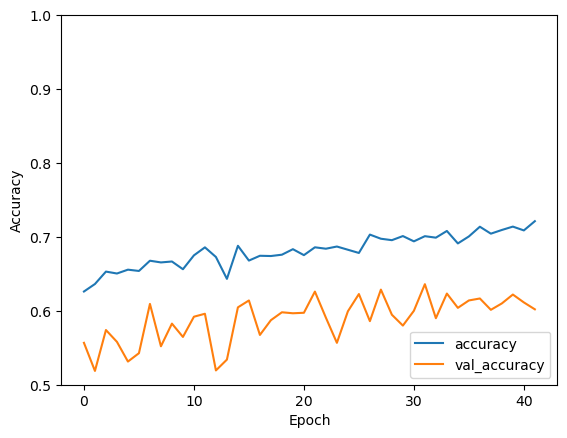

In [123]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = MLP.evaluate(test_data_shuffled,test_labels_shuffled, verbose=2)

In [69]:
one_hot_train2D_labels = OHE.fit_transform([[lab] for lab in train_labels2D]).toarray()
one_hot_valid2D_labels = OHE.fit_transform([[lab] for lab in valid_labels2D]).toarray()
one_hot_test2D_labels = OHE.fit_transform([[lab] for lab in test_labels2D]).toarray()
train_data2D_shuffled,train2D_labels_shuffled = shuffleData(np.asarray(train_data2D),one_hot_train2D_labels)
valid_data2D_shuffled,valid2D_labels_shuffled = shuffleData(np.asarray(valid_data2D),one_hot_valid2D_labels)
test_data2D_shuffled,test2D_labels_shuffled = shuffleData(np.asarray(test_data2D),one_hot_test2D_labels)

In [72]:
print(train_data2D_shuffled.shape)
print(valid_data2D_shuffled.shape)
print(test_data2D_shuffled.shape)
print(train2D_labels_shuffled.shape)
print(valid2D_labels_shuffled.shape)
print(test2D_labels_shuffled.shape)

(10000, 75, 75, 3)
(1500, 75, 75, 3)
(500, 75, 75, 3)
(10000, 5)
(1500, 5)
(500, 5)


In [174]:
CNN = tf.keras.models.Sequential()
CNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 3)))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(5,activation = 'softmax'))
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [175]:
CNN.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 7, 7, 128)      

In [176]:
history_CNN = CNN.fit(train_data2D_shuffled,train2D_labels_shuffled,epochs=100,validation_data=(valid_data2D_shuffled,valid2D_labels_shuffled),validation_batch_size=100,batch_size=100,callbacks=callback)

Epoch 1/100
100/100 [==============================] - 40s 384ms/step - loss: 2.6438 - accuracy: 0.4949 - val_loss: 1.0676 - val_accuracy: 0.5780
Epoch 2/100
100/100 [==============================] - 39s 388ms/step - loss: 0.9265 - accuracy: 0.6403 - val_loss: 0.9945 - val_accuracy: 0.6307
Epoch 3/100
100/100 [==============================] - 38s 384ms/step - loss: 0.8705 - accuracy: 0.6643 - val_loss: 0.9736 - val_accuracy: 0.6273
Epoch 4/100
100/100 [==============================] - 39s 386ms/step - loss: 0.8084 - accuracy: 0.6888 - val_loss: 0.9639 - val_accuracy: 0.6400
Epoch 5/100
100/100 [==============================] - 38s 384ms/step - loss: 0.7746 - accuracy: 0.7063 - val_loss: 0.9743 - val_accuracy: 0.6293
Epoch 6/100
100/100 [==============================] - 39s 389ms/step - loss: 0.7195 - accuracy: 0.7365 - val_loss: 0.9250 - val_accuracy: 0.6573
Epoch 7/100
100/100 [==============================] - 39s 386ms/step - loss: 0.6790 - accuracy: 0.7447 - val_loss: 1.0222 -

16/16 - 1s - loss: 1.1858 - accuracy: 0.7260 - 618ms/epoch - 39ms/step


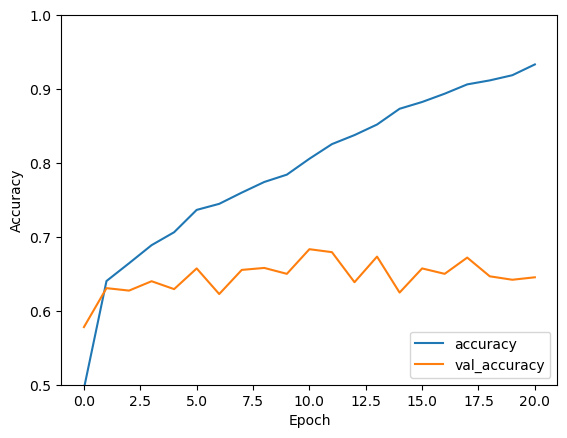

In [179]:
plt.plot(history_CNN.history['accuracy'], label='accuracy')
plt.plot(history_CNN.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = CNN.evaluate(test_data2D_shuffled,test2D_labels_shuffled, verbose=2)

# Results

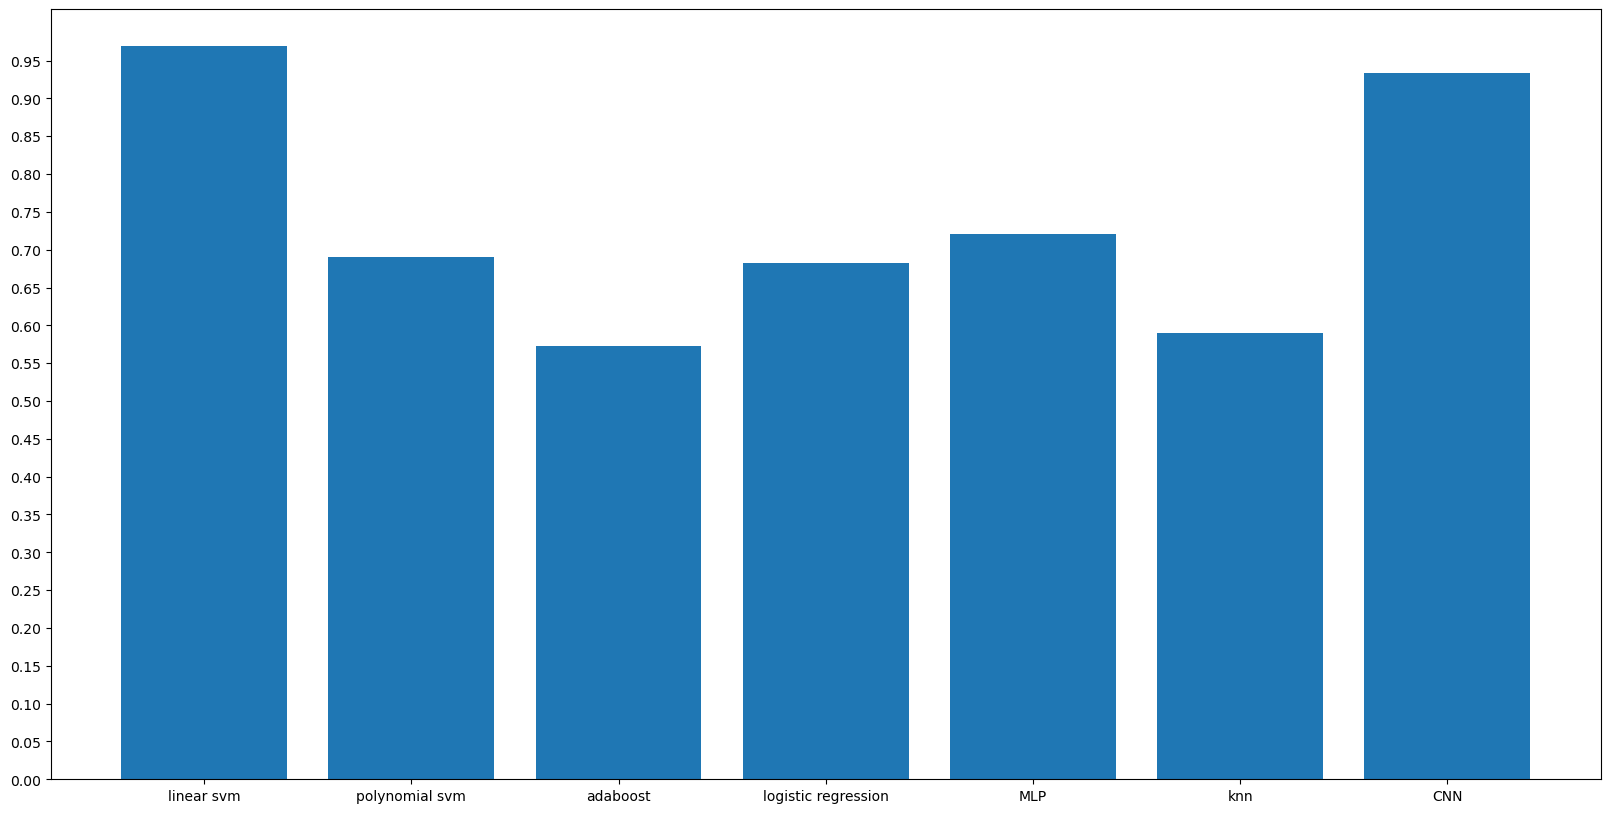

In [185]:
plt.figure(figsize = [20,10])
plt.bar(methods,final_scores_train)
plt.yticks(np.arange(0,max(final_scores_train)+0.01,0.05));

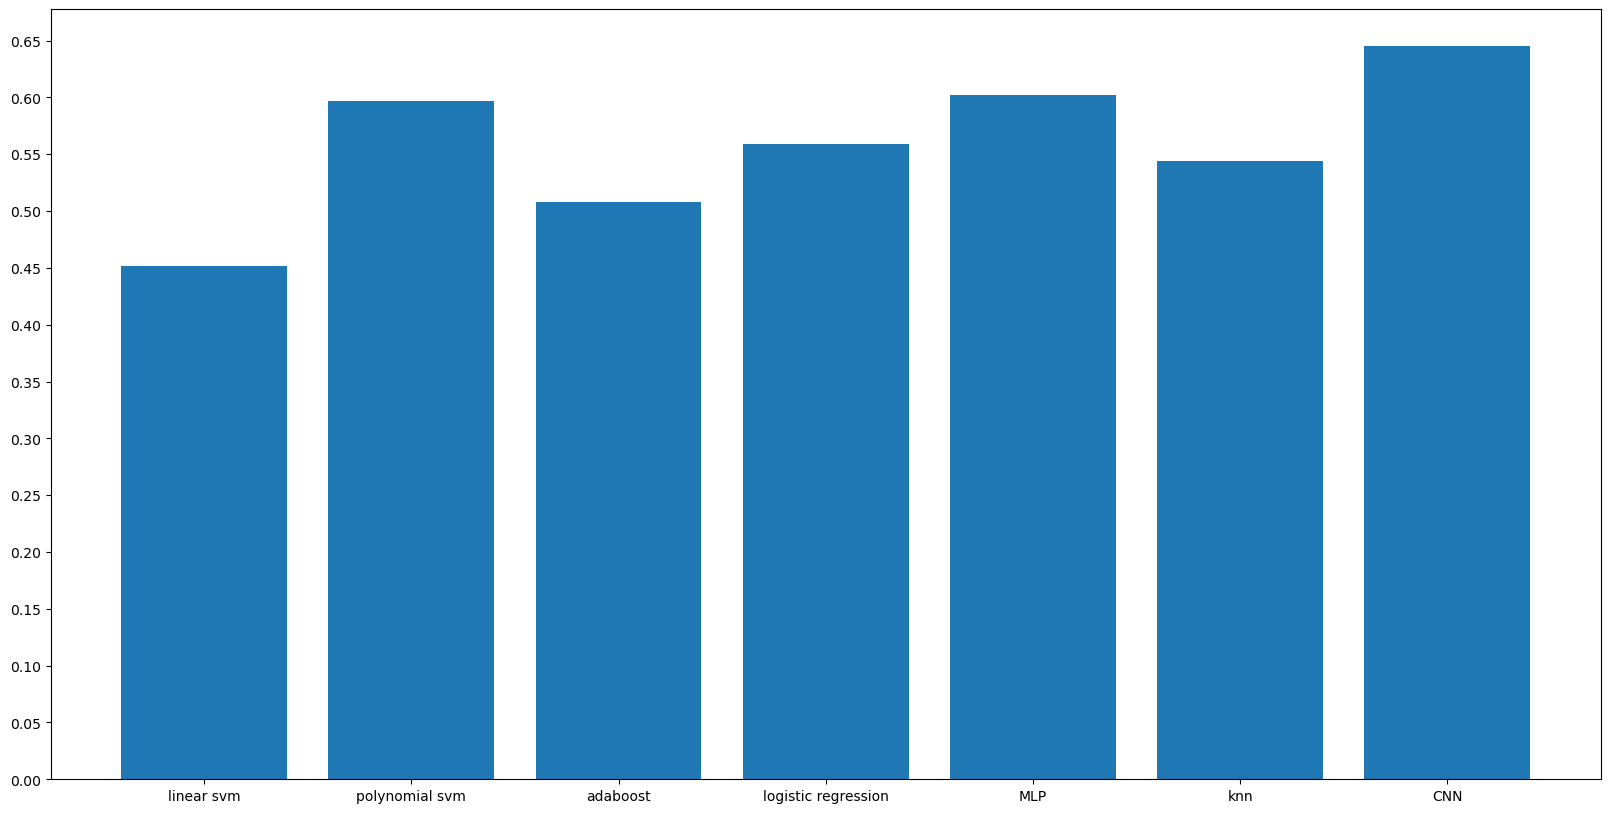

In [186]:
plt.figure(figsize = [20,10])
plt.bar(methods,final_scores_valid)
plt.yticks(np.arange(0,max(final_scores_valid)+0.01,0.05));

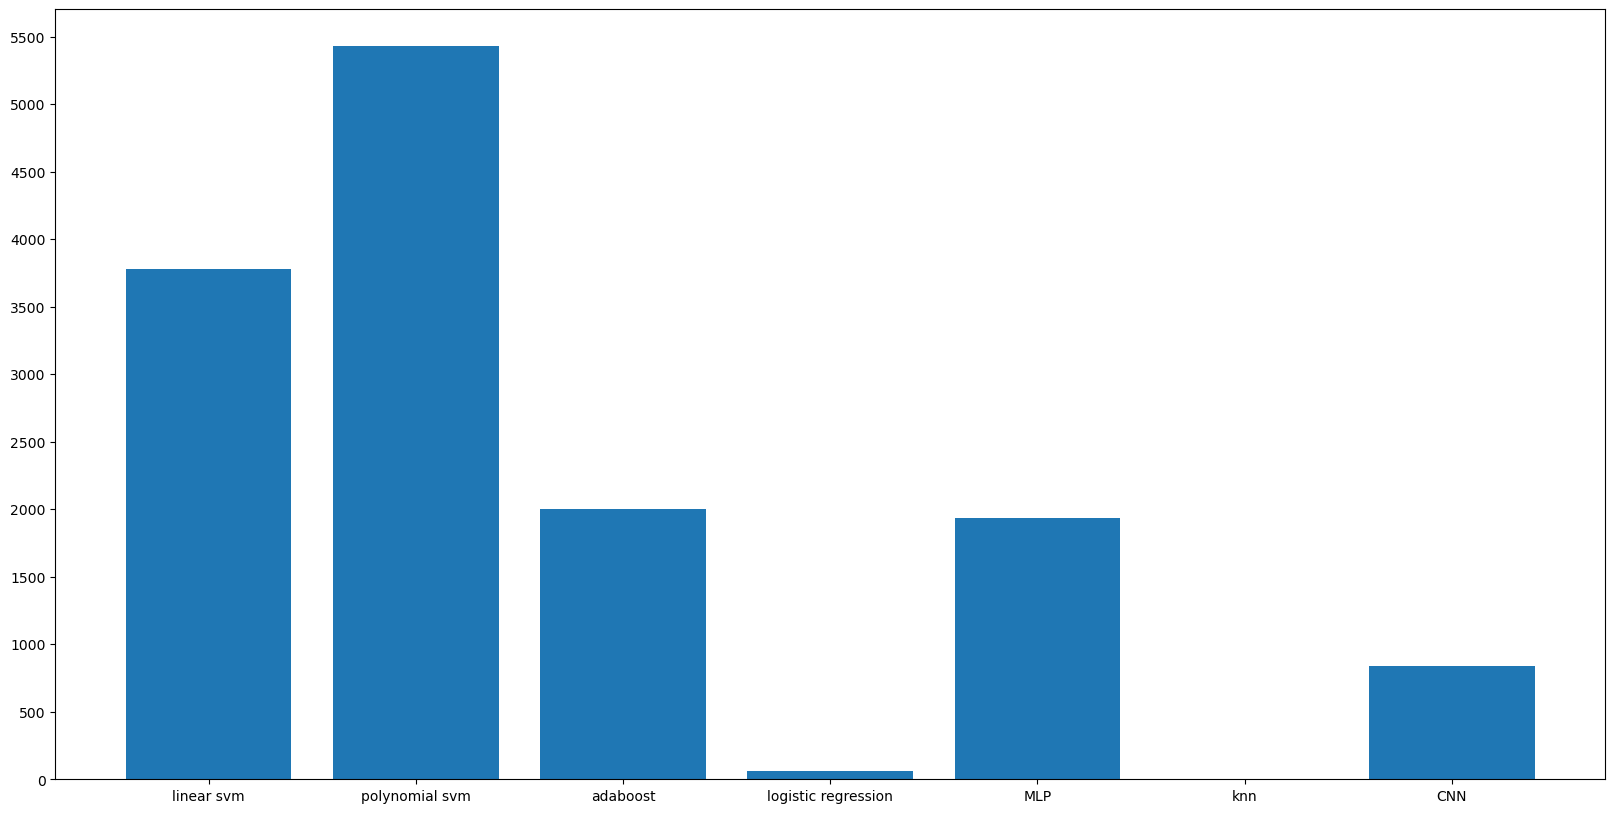

In [187]:
plt.figure(figsize = [20,10])
plt.bar(methods,seconds_to_train);
plt.yticks(np.arange(0,max(seconds_to_train)+100,500));

In [145]:
def getPreditionsLabels(prediction):
    predicions_labels = []
    for pred in prediction:
        max_index = 0
        for index in range(len(pred)):
            if pred[index] > pred[max_index]:
                max_index = index
        predicions_labels.append(max_index+1)
    return predicions_labels

In [194]:
pics = np.random.randint(len(test_data2D)-1,size=25)

16/16 [==============================] - 0s 19ms/step


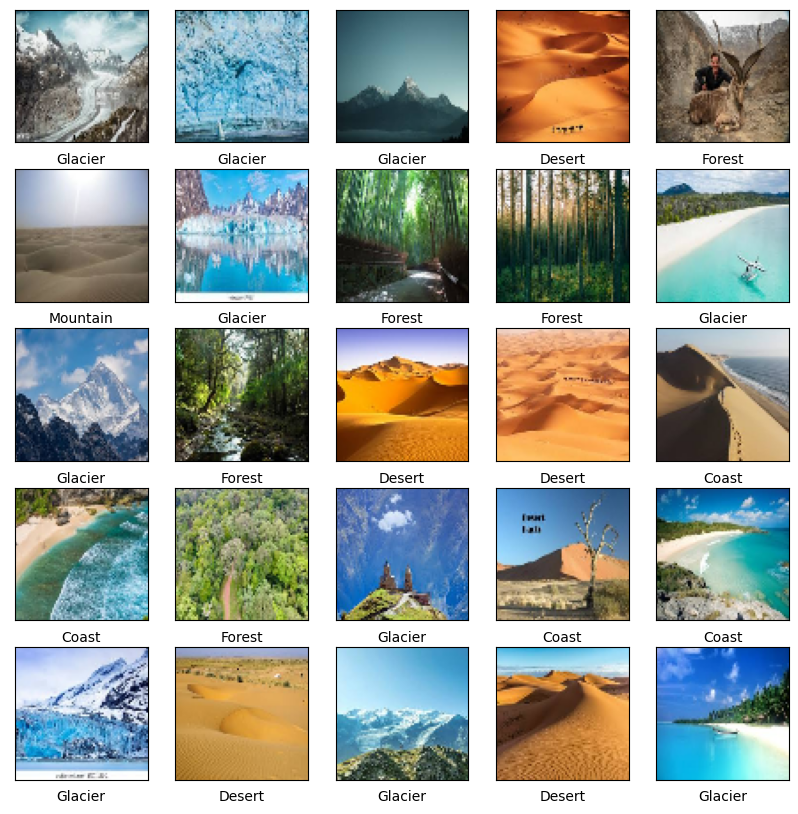

In [195]:
#MLP
predicion_mlp = MLP.predict(test_data)
labels_predict = getPreditionsLabels(predicion_mlp)
plt.figure(figsize=(10,10))
for i,index in zip(range(25),pics):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data2D[index])
    plt.xlabel(numToLabel(labels_predict[index]))
plt.show()

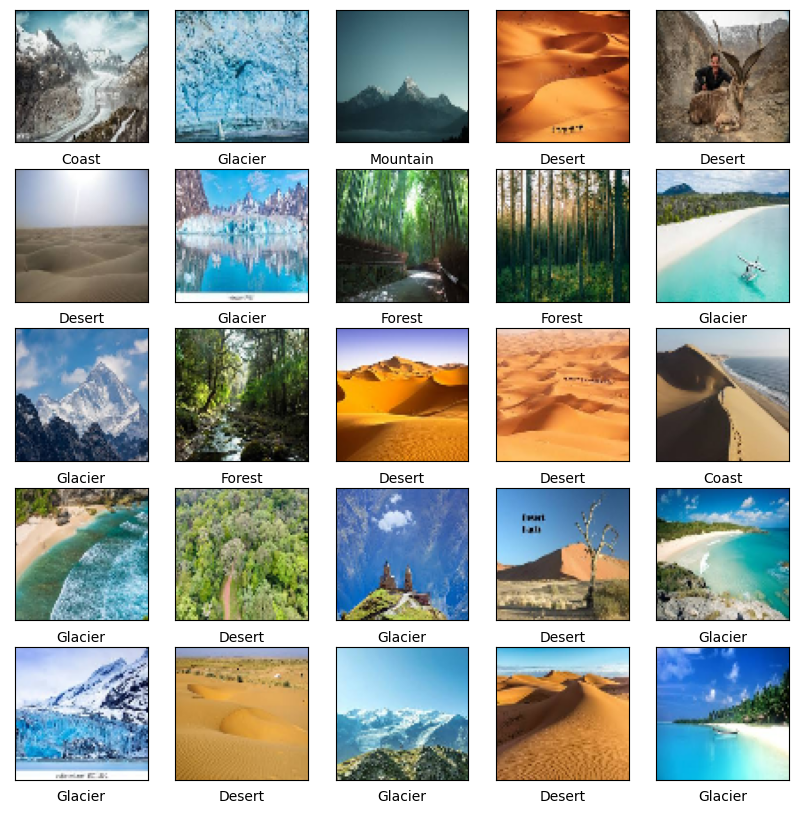

In [196]:
#KNN
predicion_KNN = knn.predict(test_data)
#labels_predict = getPreditionsLabels(predicion_mlp)
plt.figure(figsize=(10,10))
for i,index in zip(range(25),pics):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data2D[index])
    plt.xlabel(numToLabel(predicion_KNN[index]))
plt.show()

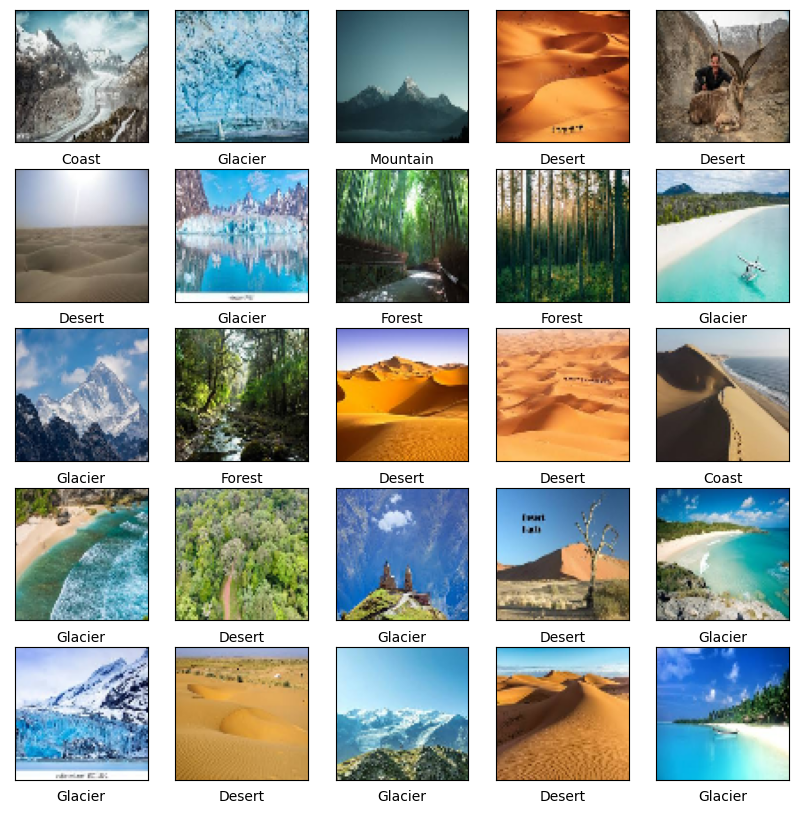

In [197]:
#Logistic
predicion_logic = logic.predict(test_data)
plt.figure(figsize=(10,10))
for i,index in zip(range(25),pics):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data2D[index])
    plt.xlabel(numToLabel(predicion_KNN[index]))
plt.show()

16/16 [==============================] - 1s 40ms/step


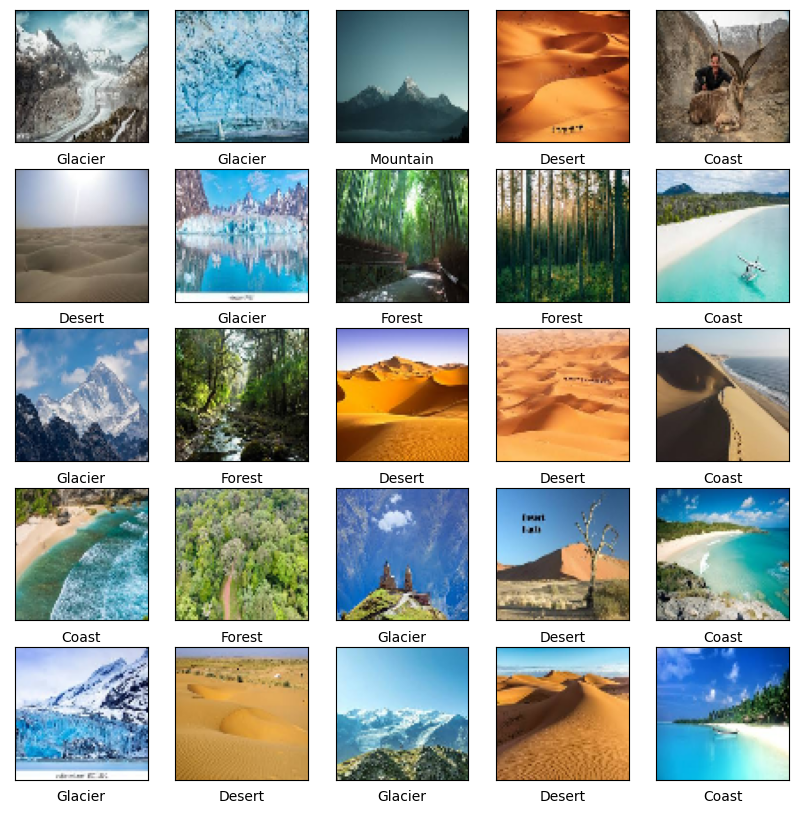

In [201]:
#CNN
predicion_cnn = CNN.predict(np.asarray(test_data2D))
labels_predict = getPreditionsLabels(predicion_cnn)
plt.figure(figsize=(10,10))
for i,index in zip(range(25),pics):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data2D[index])
    plt.xlabel(numToLabel(labels_predict[index]))
plt.show()

In [203]:
blur_images = blurImages(valid_data)
blur_2d = blurImages2D(valid_data2D)

In [205]:
print(f"knn score on blur: {knn.score(blur_images,valid_labels)}")
print(f"logistic regression score on blur: {logic.score(blur_images,valid_labels)}")
m = tf.keras.metrics.Accuracy()
blur_pred = MLP.predict(blur_images);
valid_blur_predict = getPreditionsLabels(blur_pred)
m.update_state(valid_labels,valid_blur_predict)
print(f"MLP result on blur: {m.result().numpy()}")
m.reset_state()
blur_pred = CNN.predict(np.asarray(blur_2d));
valid_blur_predict = getPreditionsLabels(blur_pred)
m.update_state(valid_labels,valid_blur_predict)
print(f"CNN result on blur: {m.result().numpy()}")

knn score on blur: 0.25866666666666666
logistic regression score on blur: 0.224
47/47 [==============================] - 1s 19ms/step
MLP result on blur: 0.2266666740179062
47/47 [==============================] - 2s 41ms/step
CNN result on blur: 0.5713333487510681


# Conclusion
- With what accuracy were we able to predict the labels?
    - The best validation score was with the CNN, with 
- How did basic ML models stand with deep learning models?
    - Even though CNN had the best accuracy, we saw the also SVM with polynomial kernel was pretty good, with the main difference being the time it took to train
- How did blurring affect the accuracy?
    - From the cell above we can see that blurring the data really throwed off our models Other then the CNN, who still had pretty good results. This may be becuase CNN learns to identify patterns better
- Additional improvments
    - To fixed the problem above, we can try and add blurry and noisey images to the training dataset.